In [1]:
!git clone -l -s -b master git://github.com/srgynmv/EmoteNN.git emotenn
%cd emotenn

Cloning into 'emotenn'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 317 (delta 9), reused 14 (delta 5), pack-reused 297
Receiving objects: 100% (317/317), 541.74 KiB | 740.00 KiB/s, done.
Resolving deltas: 100% (181/181), done.
/content/emotenn


In [86]:
%tensorflow_version 2.x
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from emotenn import constants as ct, load_utils as lu, train_utils as tu, plot_utils as pu, gen_utils as gu
# from tensorflow.keras.losses import categorical_crossentropy
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras import callbacks
# from tensorflow.keras.models import load_model, model_from_json
# from tensorflow.keras.models import Sequential, Model
# from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, ZeroPadding2D, Convolution2D
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras import applications
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras import callbacks
from keras.models import load_model, model_from_json
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, ZeroPadding2D, Convolution2D
from keras.regularizers import l2
from keras import applications
from keras.preprocessing.image import ImageDataGenerator

!pip install keras_vggface
from keras_vggface.vggface import VGGFace

## Generate the dataset

In [0]:
lu.download_file_from_google_drive(ct.FER_ARCHIVE, exist_ok=True)
gu.unpack(ct.FER_ARCHIVE.path)

In [0]:
FER_CSV_PATH = os.path.join(ct.UNPACKED_DIR, 'fer2013', 'fer2013.csv')
FER_WIDTH = 48
FER_HEIGHT = 48

data = pd.read_csv(FER_CSV_PATH)

TARGET_DIR = os.path.join(ct.DATASETS_DIR, 'fer2013_images')

for class_name in ct.CLASS_NAMES:
        os.makedirs(os.path.join(TARGET_DIR, class_name), exist_ok=True)

for index, row in data.iterrows():
    image = [int(pixel) for pixel in row['pixels'].split(' ')]
    image = np.asarray(image, dtype=np.float32).reshape(FER_WIDTH, FER_HEIGHT)
    path = os.path.join(TARGET_DIR, ct.CLASS_NAMES[int(row['emotion'])], f'{index:05}.png')
    plt.imsave(path, image, cmap='gray')

## Train model

In [17]:
strategy = tu.get_distribution_strategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [144]:
def build_model():
    vgg_notop = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    last_layer = vgg_notop.get_layer('avg_pool').output
    x = Flatten(name='flatten')(last_layer)
    x = Dense(4096, activation='relu', name='fc6')(x)
    x = Dense(1024, activation='relu', name='fc7')(x)
    for i in range(101):
        vgg_notop.layers[i].trainable = False

    out = Dense(7, activation='softmax', name='classifier')(x)
    custom_resnet = Model(vgg_notop.input, out)
    return custom_resnet

#with strategy.scope():
with tf.device('/device:GPU:0'):
    model = build_model()
    print(model.summary())
    model.compile(optimizer='sgd',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_15[0][0]                   
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_589 (Activation)     (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________________

In [145]:
batch_size = 32

data_gen = ImageDataGenerator(validation_split=0.15,
                              rescale=1./255)
train_data = data_gen.flow_from_directory(TARGET_DIR,
                                          classes=ct.CLASS_NAMES,
                                          target_size=(224, 224),
                                          batch_size=batch_size,
                                          subset='training')
valid_data = data_gen.flow_from_directory(TARGET_DIR,
                                          classes=ct.CLASS_NAMES,
                                          target_size=(224, 224),
                                          batch_size=batch_size,
                                          subset='validation')

Found 30507 images belonging to 7 classes.
Found 5380 images belonging to 7 classes.


In [0]:
def get_callbacks(model_name):
    path = os.path.join(ct.CHECKPOINTS_DIR, model_name + '-{epoch:02d}-{val_accuracy:.2f}.h5')
    os.makedirs(ct.CHECKPOINTS_DIR, exist_ok=True)

#    early_stopping = callbacks.EarlyStopping(verbose=1, patience=10, monitor='val_accuracy', mode='max')
    plateau = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, verbose=0, mode='max',
                                                epsilon=0.0001, cooldown=0, min_lr=0)
    checkpoint = callbacks.ModelCheckpoint(path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    return [plateau, checkpoint]

In [148]:
epochs = 10
cb = get_callbacks('resnet')

train_history_2 = model.fit(x=train_data,
                          steps_per_epoch=train_data.samples // train_data.batch_size,
                          validation_data=valid_data,
                          validation_steps=valid_data.samples // valid_data.batch_size,
                          callbacks=cb,
                          epochs=epochs,
                          initial_epoch=4)

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Epoch 5/10
953/953 [==============================] - 546s 572ms/step - loss: 0.1929 - accuracy: 0.9348 - val_loss: 1.8564 - val_accuracy: 0.1427

Epoch 00005: val_accuracy improved from -inf to 0.14267, saving model to /content/emotenn/results/checkpoints/resnet-05-0.14.h5
Epoch 6/10
953/953 [==============================] - 544s 571ms/step - loss: 0.2092 - accuracy: 0.9278 - val_loss: 2.2597 - val_accuracy: 0.1687

Epoch 00006: val_accuracy improved from 0.14267 to 0.16866, saving model to /content/emotenn/results/checkpoints/resnet-06-0.17.h5
Epoch 7/10
953/953 [==============================] - 545s 572ms/step - loss: 0.1427 - accuracy: 0.9519 - val_loss: 1.9840 - val_accuracy: 0.1371

Epoch 00007: val_accuracy did not improve from 0.16866
Epoch 8/10
953/953 [==============================] - 545s 572ms/step - loss: 0.1166 - accuracy: 0.9614 - val_loss: 1.9018 - val_accuracy: 0.1376

Epoch 00008: val_accuracy did not improve from 0.16866
Epoch 9/10
953/953 [=======================

169/169 [==============================] - 54s 321ms/step
Dataset accuracy: 11.15%


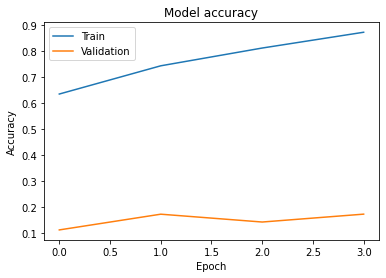

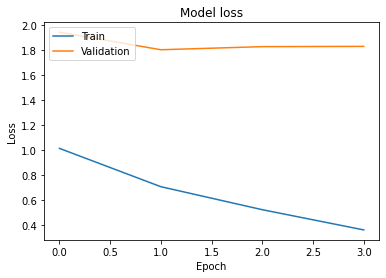

In [149]:
#score = model.evaluate(X_test, Y_test)
#score = model.evaluate(test_data.x, test_data.y)
score = model.evaluate(x=valid_data)
print("Dataset {}: {:.2f}%".format(model.metrics_names[1], score[1] * 100))
pu.plot_model_history(train_history.history)

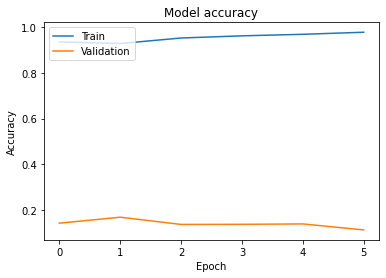

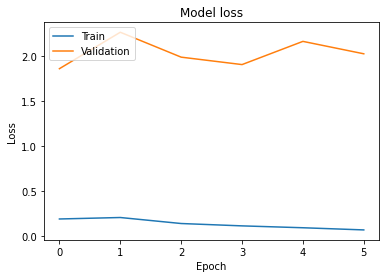

In [151]:
pu.plot_model_history(train_history_2.history)

In [154]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_prediction = model.predict_generator(valid_data)

# Convert classification results to one hot vectors 
Y_pred_classes = np.argmax(Y_prediction, axis=1) 
Y_true = np.argmax(Y_valid, axis=1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', xticklabels=ct.CLASS_NAMES, yticklabels=ct.CLASS_NAMES)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

ValueError: ignored

In [0]:
tu.save_results(model, train_history, model_name)

Model is saved to /content/emotenn/trained_models/model.h5
Train history is saved to /content/emotenn/trained_models/model_history.pkl


In [0]:
train_history = model.fit(x=train_data,
                          validation_data=valid_data,
                          callbacks=callbacks,
                          epochs=epochs)

Epoch 1/100
91/91 [==============================] - 81s 892ms/step - loss: 1.3027 - accuracy: 0.5160 - val_loss: 1.2786 - val_accuracy: 0.5399
Epoch 2/100
91/91 [==============================] - 81s 890ms/step - loss: 1.3013 - accuracy: 0.5187 - val_loss: 1.2779 - val_accuracy: 0.5402
Epoch 3/100
91/91 [==============================] - 81s 892ms/step - loss: 1.3029 - accuracy: 0.5152 - val_loss: 1.2773 - val_accuracy: 0.5403
Epoch 4/100
91/91 [==============================] - 81s 892ms/step - loss: 1.3014 - accuracy: 0.5153 - val_loss: 1.2768 - val_accuracy: 0.5406
Epoch 5/100
91/91 [==============================] - 82s 902ms/step - loss: 1.3011 - accuracy: 0.5137 - val_loss: 1.2765 - val_accuracy: 0.5406
Epoch 6/100
91/91 [==============================] - 81s 891ms/step - loss: 1.2976 - accuracy: 0.5157 - val_loss: 1.2756 - val_accuracy: 0.5417
Epoch 7/100
91/91 [==============================] - 81s 891ms/step - loss: 1.3016 - accuracy: 0.5157 - val_loss: 1.2753 - val_accuracy:

KeyboardInterrupt: ignored

22/22 [==============================] - 13s 613ms/step - loss: 1.2805 - accuracy: 0.5425
Dataset accuracy: 54.25%


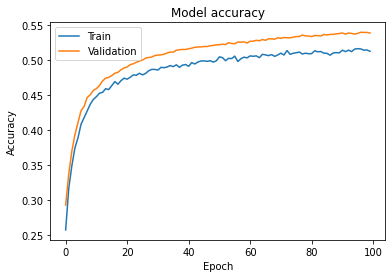

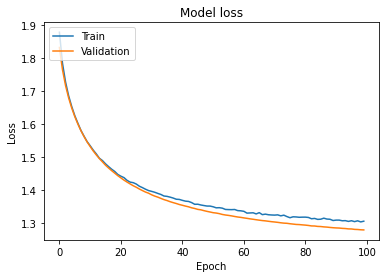

In [0]:
score = model.evaluate(x=test_data)
print("Dataset {}: {:.2f}%".format(model.metrics_names[1], score[1] * 100))
pu.plot_model_history(train_history.history)